# Лабораторная работа №1

In [ ]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [ ]:
# Reloading editable packages.
%autoreload
# from lab1.main import get_results

Вариант для задания №3:
1. Номер группы + 15 = 2 + 15 = 17
2. Номер варианта + 56 = 14 + 56 = 70
3. ИУ5 (Номер варианта + 21) = 14 + 21 = 35

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Задача регрессии по теореме универсальной аппроксимации, ручное дифференцирование
Генерация выборки и инициализация параметров нейронной сети

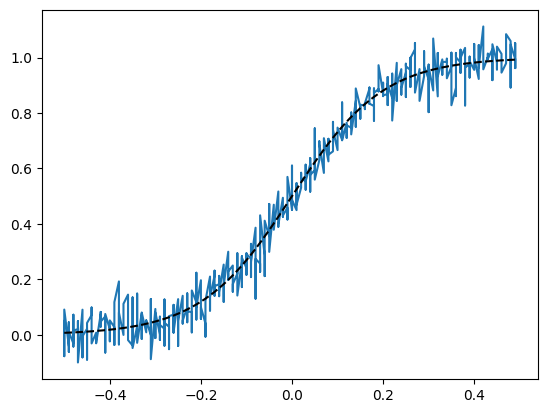

In [2]:
X = (np.arange(100)/100 - 0.5).repeat(5)

y = 1/(1+np.exp(-10*X))
yn = np.random.normal(scale=0.05, size=y.size)+y

plt.plot(X, yn)
plt.plot(X, y, linestyle='--', c='k')
################################################
tensor_X = torch.Tensor(X.reshape(-1, 1))
tensor_y = torch.Tensor(yn.reshape(-1, 1))

HIDDEN_SIZE = 64
# Инициализация весов MLP с одним скрытым слоём
weights_1 = (torch.rand(1, HIDDEN_SIZE)-.5)/10
bias_1 = torch.zeros(HIDDEN_SIZE)

weights_2 = (torch.rand(HIDDEN_SIZE, 1)-.5)/10
bias_2 = torch.zeros(1)

### Обучение нейронной сети задачи регрессии

0.0027880915


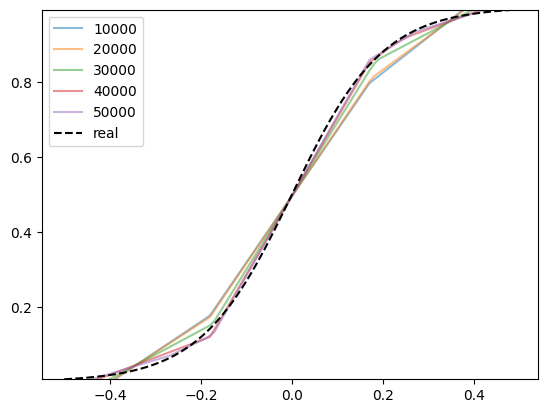

In [3]:
# Определяем функцию нелинейности
relu = lambda x: torch.maximum(x, torch.Tensor([0]))
# Прямой проход
forward = lambda x: (weights_2.t()*relu((weights_1*x) + bias_1)
                    ).sum(axis=-1, keepdims=True) + bias_2
loss = lambda y, y_: ((y-y_)**2).sum(axis=-1)


# обратный проход
def backward(X, y, y_pred):
    # производная функции потерь по y_pred
    dL = 2*(y_pred-y)
    # значения нейронов скрытого слоя до применения активации
    Ax = (weights_1*X) + bias_1
    # значения нейронов скрытого слоя после применения активации
    A = relu(Ax)
    # производная функции потерь по weight_2
    dW2 = torch.mm(A.t(), dL)
    # производная функции потерь по bias_2
    db2 = dL.sum(axis=0)
    # производная функции потерь по значениям скрытого слоя после активации
    dA = torch.mm(dL, weights_2.t())
    # производная функции потерь по значениям скрытого слоя до активации
    dA[Ax <= 0] = 0
    # производная функции потерь по weight_1
    dW = torch.mm(X.t(), dA)
    # производная функции потерь по bias_1
    db = dA.sum(axis=0)
    # print(dW.shape, db.shape, dW2.shape, db2.shape)
    return dW, db, dW2, db2


def optimize(params, grads, lr=0.001):
    # градиентный спуск по всей обучающей выборке
    W1, b1, W2, b2 = params
    W1 -= lr*grads[0]
    W2 -= lr*grads[2]
    b1 -= lr*grads[1]
    b2 -= lr*grads[3]
    return W1, b1, W2, b2


# 50 тысяч итераций градиентного спуска == 50 тысяч эпох
for i in range(50000):
    output = forward(tensor_X)
    cur_loss = loss(output, tensor_y)
    grads = backward(tensor_X, tensor_y, output)
    params = [weights_1, bias_1, weights_2, bias_2]
    weights_1, bias_1, weights_2, bias_2 = optimize(params, grads, 1e-4)
    if (i+1) % 10000 == 0:
        plt.plot(X, output.numpy(), label=str(i+1), alpha=0.5)

plt.plot(X, y, linestyle='--', c='k', label='real')
plt.legend()
plt.ylim(y.min(), y.max())
print(cur_loss.numpy().mean())

## Часть 2. Бинарная классификация с помощью автодиффиренцирования PyTorch
Генерация выборки и инициализация параметров нейронной сети

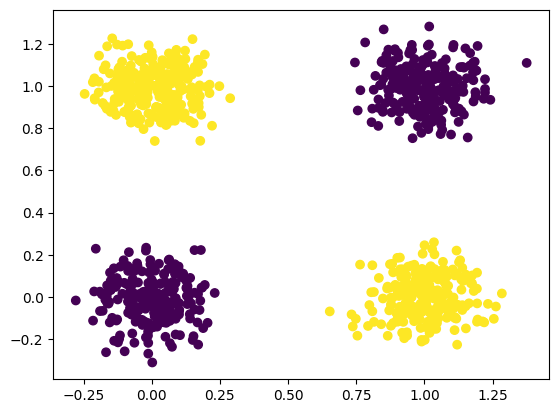

In [4]:
X = np.random.randint(2, size=(1000, 2))

y = (X[:, 0] + X[:, 1]) % 2  # XOR
X = X + np.random.normal(0, scale=0.1, size=X.shape)
# X, y = make_circles(n_samples=1000, noise=0.025)
# X, y = make_moons(n_samples=1000, noise=0.025)
plt.scatter(X[:, 0], X[:, 1], c=y)
####################################################
tensor_X = torch.Tensor(X.reshape(-1, 2))
tensor_y = torch.Tensor(y.reshape(-1, 1))

HIDDEN_SIZE = 16
# Инициализация весов MLP с одним скрытым слоём
weights_1 = ((torch.rand(2, HIDDEN_SIZE)-.5)/10).detach().requires_grad_(True)
bias_1 = torch.zeros(HIDDEN_SIZE, requires_grad=True)

weights_2 = ((torch.rand(HIDDEN_SIZE, 1)-.5)/10).detach().requires_grad_(True)
bias_2 = torch.zeros(1, requires_grad=True)

### Обучение нейронной сети задачи классификации

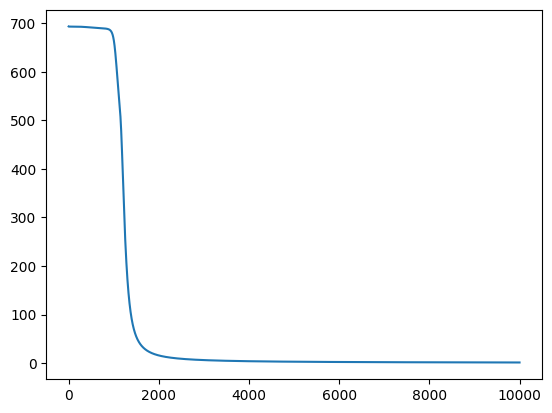

In [5]:
# Определяем функцию нелинейности
def sigmoid(x):
    return 1/(1+torch.exp(-x))


# Прямой проход
def forward(x):
    hidden = torch.mm(x, weights_1) + bias_1
    hidden_nonlin = sigmoid(hidden)
    output = (weights_2.t()*hidden_nonlin).sum(axis=-1, keepdims=True) + bias_2

    return sigmoid(output)


# Logloss
def loss(y_true, y_pred):
    return -1*(y_true*torch.log(y_pred)+(1-y_true)*torch.log(1-y_pred)).sum()


# задаём шаг обучения
lr = 1e-3
# задаём число итераций
iters = 10000
params = [weights_1, bias_1, weights_2, bias_2]
losses = []
for i in range(iters):
    output = forward(tensor_X)
    lossval = loss(tensor_y, output)
    lossval.backward()  # тут включается в работу autograd
    for w in params:
        with torch.no_grad():
            w -= w.grad*lr  # обновляем веса
        w.grad.zero_()  # зануляем градиенты, чтобы не накапливались за итерации
    losses.append(lossval.item())
# выводим историю функции потерь по итерациям
plt.plot(losses)

### Проверка результатов обучения

(-0.47993658882179957, 1.543514402678591)

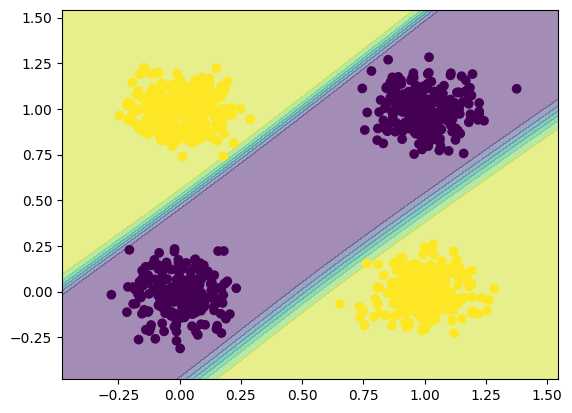

In [6]:
X_diff = X.max() - X.min()
X_left = X.min() - 0.1*X_diff
X_right = X.max() + 0.1*X_diff
grid = np.arange(X_left, X_right, 0.01)
grid_width = grid.size
surface = []
# создаем точки по сетке
for x1 in grid:
    for x2 in grid:
        surface.append((x1, x2))
surface = np.array(surface)
# получаем предсказания для всех точек
with torch.no_grad():
    Z = forward(torch.Tensor(surface)).detach().numpy()
# меняем форму в виде двухмерного массива
Z = Z.reshape(grid_width, grid_width)
xx = surface[:, 0].reshape(grid_width, grid_width)
yy = surface[:, 1].reshape(grid_width, grid_width)
# рисуем разделяющие поверхности классов
plt.contourf(xx, yy, Z, alpha=0.5)
# рисуем обучающую выборку
plt.scatter(X[:, 0], X[:, 1], c=output.detach().numpy() > 0.5)
# задаём границы отображения графика
plt.xlim(X_left, X_right)
plt.ylim(X_left, X_right)

## Часть 3. Классификация изображений CIFAR100
Загрузка и распаковка набора данных CIFAR100

In [27]:
import urllib
import shutil
from pathlib import Path

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
data_path = Path("data")

data_path.mkdir(exist_ok=True)

file_path = data_path/filename

urllib.request.urlretrieve(url, file_path)
shutil.unpack_archive(file_path, extract_dir=data_path)
file_path.unlink()